In [1]:
import catboost as cb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv('earthquakes.csv')

df.time = pd.to_datetime(df.time)
df = df.loc[df.time >= "1994-01-01"]
df = df.sort_values("time")
df = df.set_index("time")

df["region"] = df.place.str.split(", ", expand=True)[1]
df.region = df.region.fillna(df.place)
df.region = df.region.replace({"CA": "California", "B.C.": "Baja California"})

regions = df.region.value_counts()
top_k = 25
top_k_regions = regions.head(top_k).index
print(top_k_regions)

Index(['California', 'Alaska', 'Nevada', 'Hawaii', 'Washington', 'Utah',
       'Montana', 'Puerto Rico', 'Indonesia', 'Chile', 'Baja California',
       'Oklahoma', 'Japan', 'Greece', 'Papua New Guinea', 'Philippines',
       'Mexico', 'Italy', 'Russia', 'Idaho', 'Aleutian Islands', 'Tonga',
       'Oregon', 'Wyoming', 'Turkey'],
      dtype='object', name='region')


In [3]:
model = cb.CatBoostRegressor(cat_features=['region'])
model = model.load_model('multi_output_model')

In [4]:
start_lag = 3
end_lag = 10
features = (
    [
        "day",
        "dayofweek",
        "dayofyear",
        f"mag_rolling_mean_{start_lag}",
        f"mag_rolling_std_{start_lag}",
        f"depth_rolling_mean_{start_lag}",
        f"depth_rolling_std_{start_lag}",
        f"mag_rolling_mean_{end_lag}",
        f"mag_rolling_std_{end_lag}",
        f"depth_rolling_mean_{end_lag}",
        f"depth_rolling_std_{end_lag}",
    ]
    + [f"mag_lag_{i}" for i in range(start_lag, end_lag + 1)]
    + [f"depth_lag_{i}" for i in range(start_lag, end_lag + 1)]
)
cat_features = ["region"]
target = ["mag", "depth"]

In [5]:
live_data = pd.read_csv(
    "https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&eventtype=earthquake&limit=20000"
)
live_data.time = pd.to_datetime(live_data.time)
live_data = live_data.sort_values("time")
live_data = live_data.set_index("time")

live_data["region"] = live_data.place.str.split(", ", expand=True)[1]
live_data.region = live_data.region.fillna(live_data.place)
live_data.region = live_data.region.replace({"CA": "California", "B.C.": "Baja California"})

live_data = live_data.loc[live_data.region.isin(top_k_regions)]

live_data = live_data[["depth", "mag", "region"]]

live_data = live_data.groupby("region").resample("d").mean().reset_index()
live_data.mag = live_data.groupby("region").mag.ffill()
live_data.depth = live_data.groupby("region").depth.ffill()

live_data["day"] = live_data.time.dt.day
live_data["dayofweek"] = live_data.time.dt.dayofweek
live_data["dayofyear"] = live_data.time.dt.dayofyear

for i in range(start_lag, end_lag + 1):
    live_data[f"mag_lag_{i}"] = live_data.groupby("region").mag.shift(i)

for i in range(start_lag, end_lag + 1):
    live_data[f"depth_lag_{i}"] = live_data.groupby("region").depth.shift(i)

live_data[f"mag_rolling_mean_{start_lag}"] = live_data.groupby("region").mag.transform(
    lambda x: x.rolling(window=start_lag).mean()
)
live_data[f"mag_rolling_std_{start_lag}"] = live_data.groupby("region").mag.transform(
    lambda x: x.rolling(window=start_lag).std()
)
live_data[f"depth_rolling_mean_{start_lag}"] = live_data.groupby("region").depth.transform(
    lambda x: x.rolling(window=start_lag).mean()
)
live_data[f"depth_rolling_std_{start_lag}"] = live_data.groupby("region").depth.transform(
    lambda x: x.rolling(window=start_lag).std()
)

live_data[f"mag_rolling_mean_{end_lag}"] = live_data.groupby("region").mag.transform(
    lambda x: x.rolling(window=end_lag).mean()
)
live_data[f"mag_rolling_std_{end_lag}"] = live_data.groupby("region").mag.transform(
    lambda x: x.rolling(window=end_lag).std()
)
live_data[f"depth_rolling_mean_{end_lag}"] = live_data.groupby("region").depth.transform(
    lambda x: x.rolling(window=end_lag).mean()
)
live_data[f"depth_rolling_std_{end_lag}"] = live_data.groupby("region").depth.transform(
    lambda x: x.rolling(window=end_lag).std()
)

In [6]:
live_data.head()

,region,time,depth,mag,day,dayofweek,dayofyear,mag_lag_3,mag_lag_4,mag_lag_5,...,depth_lag_9,depth_lag_10,mag_rolling_mean_3,mag_rolling_std_3,depth_rolling_mean_3,depth_rolling_std_3,mag_rolling_mean_10,mag_rolling_std_10,depth_rolling_mean_10,depth_rolling_std_10
0,Alaska,2024-05-09 00:00:00+00:00,39.597059,1.336078,9,3,130,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alaska,2024-05-10 00:00:00+00:00,24.873725,1.051765,10,4,131,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alaska,2024-05-11 00:00:00+00:00,12.966100,0.923800,11,5,132,NaN,NaN,NaN,...,NaN,NaN,1.103881,0.211022,25.812295,13.340265,NaN,NaN,NaN,NaN
3,Alaska,2024-05-12 00:00:00+00:00,24.525171,1.023429,12,6,133,1.336078,NaN,NaN,...,NaN,NaN,0.999664,0.067211,20.788332,6.776493,NaN,NaN,NaN,NaN
4,Alaska,2024-05-13 00:00:00+00:00,21.300727,1.374380,13,0,134,1.051765,1.336078,NaN,...,NaN,NaN,1.107203,0.236684,19.597333,5.964830,NaN,NaN,NaN,NaN


In [7]:
live_prediction = model.predict(live_data[features + cat_features])
print(f"Mean Absolute Error: {mean_absolute_error(live_data[target], live_prediction)}")
print(
    f"Root Mean Squared Error: {np.sqrt(mean_squared_error(live_data[target], live_prediction))}"
)
print(f"R2 Score: {r2_score(live_data[target], live_prediction)}")

Mean Absolute Error: 7.931970590794431
Root Mean Squared Error: 26.236798189036648
R2 Score: 0.742491765817491


In [8]:
df_live = pd.DataFrame(live_prediction, columns=['mag_forecast', 'depth_forecast'])
df_live.head()

,mag_forecast,depth_forecast
0,2.965474,46.746592
1,2.929998,48.587308
2,1.463586,28.958420
3,1.159613,20.061288
4,1.210010,18.997988


In [9]:
df_true = live_data[['time'] + cat_features + target]
df_true.head()

,time,region,mag,depth
0,2024-05-09 00:00:00+00:00,Alaska,1.336078,39.597059
1,2024-05-10 00:00:00+00:00,Alaska,1.051765,24.873725
2,2024-05-11 00:00:00+00:00,Alaska,0.923800,12.966100
3,2024-05-12 00:00:00+00:00,Alaska,1.023429,24.525171
4,2024-05-13 00:00:00+00:00,Alaska,1.374380,21.300727


In [10]:
df_combined = df_true.join(df_live)
df_combined.head()

,time,region,mag,depth,mag_forecast,depth_forecast
0,2024-05-09 00:00:00+00:00,Alaska,1.336078,39.597059,2.965474,46.746592
1,2024-05-10 00:00:00+00:00,Alaska,1.051765,24.873725,2.929998,48.587308
2,2024-05-11 00:00:00+00:00,Alaska,0.923800,12.966100,1.463586,28.958420
3,2024-05-12 00:00:00+00:00,Alaska,1.023429,24.525171,1.159613,20.061288
4,2024-05-13 00:00:00+00:00,Alaska,1.374380,21.300727,1.210010,18.997988


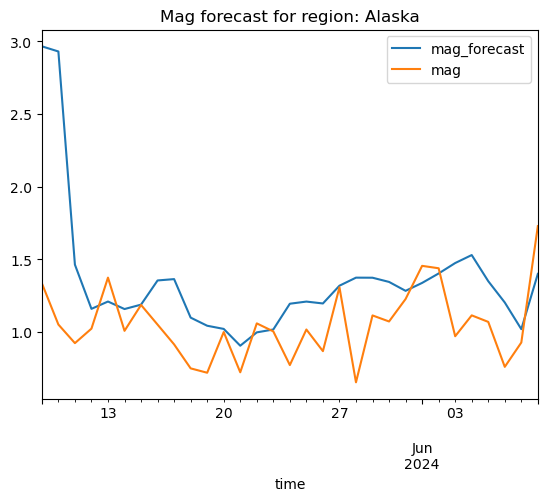

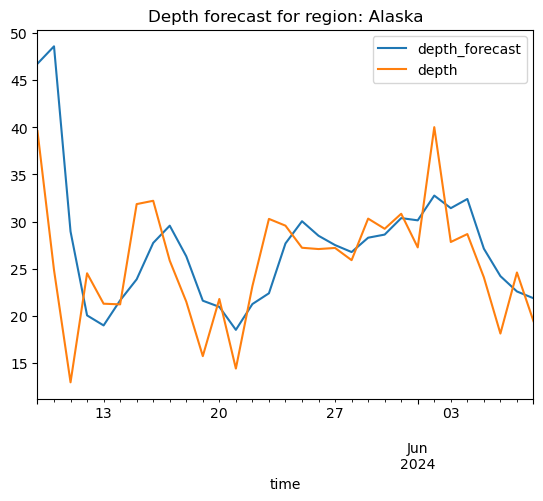

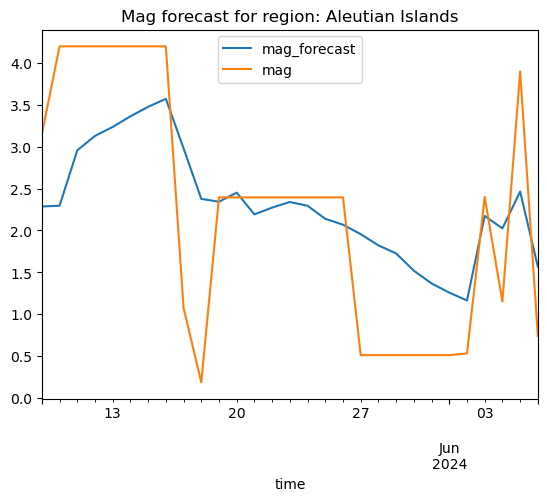

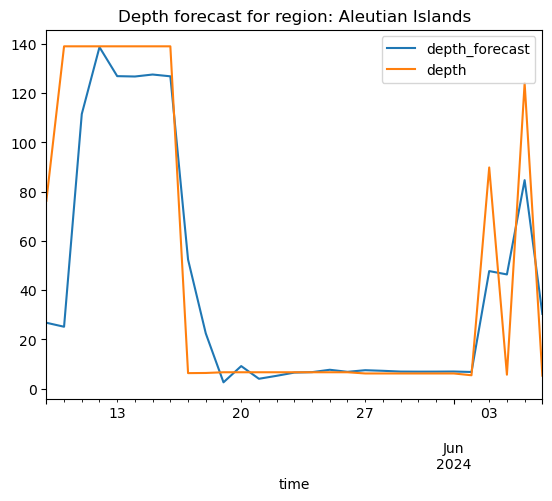

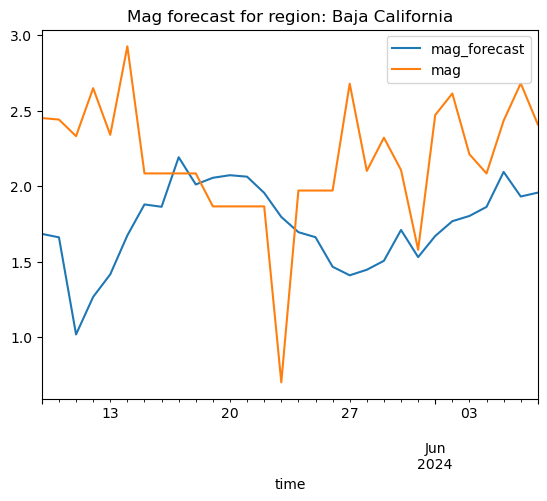

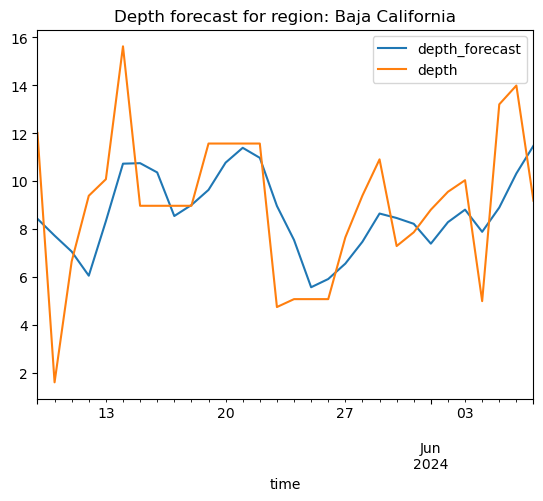

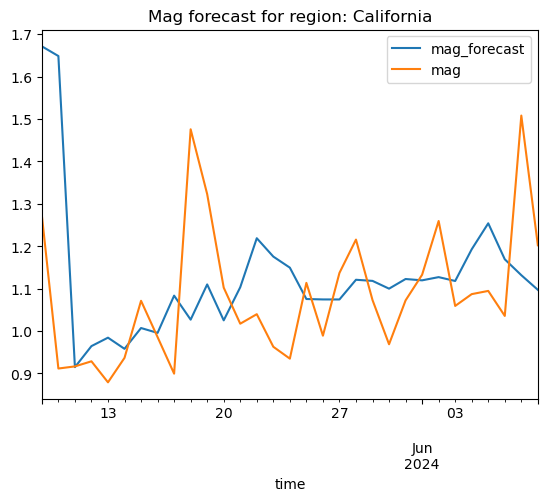

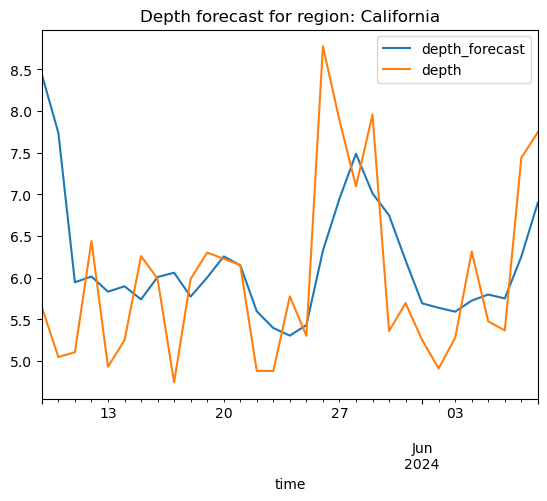

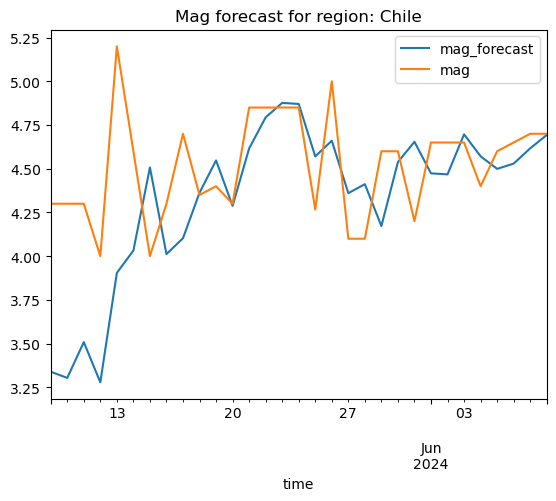

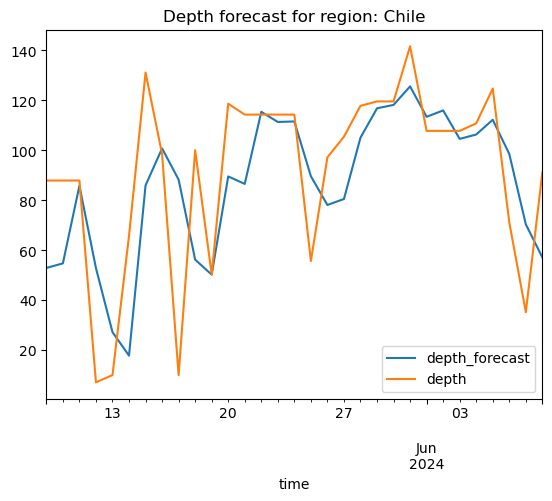

In [11]:
k = 5
for region in df_combined.region.unique():
    df_region = df_combined.loc[df_combined.region == region]
    df_region.plot(title=f"Mag forecast for region: {region}", x='time', y=['mag_forecast', 'mag'])
    df_region.plot(title=f"Depth forecast for region: {region}", x='time', y=['depth_forecast', 'depth'])
    k -= 1
    if not k:
        break